# Load Libraries

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2) ; packageVersion("dada2")
library(decontam) ; packageVersion("decontam")
library(ggplot2); packageVersion("ggplot2")
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(Biostrings); packageVersion("Biostrings")
#library(DECIPHER) ; packageVersion("DECIPHER")
library(tidyr)
library(dplyr)
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(tibble) ; packageVersion("tibble")
library(microViz)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

library(viridis)
#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] '1.46.0'

Loading required package: Rcpp



[1] '1.30.0'

[1] '1.22.0'

[1] '3.5.0'

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



[1] '2.6.4'

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:phylose

[1] '1.42.0'

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit




[1] '2.70.1'


Attaching package: 'tidyr'


The following object is masked from 'package:S4Vectors':

    expand



Attaching package: 'dplyr'


The following objects are masked from 'package:Biostrings':

    collapse, intersect, setdiff, setequal, union


The following object is masked from 'package:XVector':

    slice


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from '

[1] '3.2.1'

microViz version 0.12.1 - Copyright (C) 2021-2024 David Barnett
! Website: https://david-barnett.github.io/microViz
✔ Useful?  For citation details, run: `citation("microViz")`
✖ Silence? `suppressPackageStartupMessages(library(microViz))`
Loading required package: viridisLite


Attaching package: 'viridis'


The following object is masked from 'package:scales':

    viridis_pal




In [2]:
ps_raw <- readRDS("C:/Users/almab/ps_raw_from_dada2_new.rds")
ps_raw
#ps_raw_from_dada2.rds
#seqtab_finaln1e9_maxEE2.rds

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3787 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3787 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3787 reference sequences ]

In [3]:
#make "combined" column in tax table
ranks <- c("Phylum", "Family", "Genus")
combined_labels <- apply(tax_table(ps_raw)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
tax_table(ps_raw) <- cbind(tax_table(ps_raw), combined=combined_labels)


In [4]:
#sub NA for Low values
sample_data(ps_raw)[sample_data(ps_raw)=="too low"] <- NA 
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[sample_data(ps_raw)$DNA_Ext_conc_ngperuL=="too low"] <- NA
#convert from factor to decimal
sample_data(ps_raw)$DNA_Ext_conc_ngperuL <- as.numeric(as.character(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)) 
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[is.na(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)] <- 0.0002

In [5]:
#remove samples with too few reads
min_reads <- 0 #7500
ps <- prune_samples(sample_sums(ps_raw)>=min_reads, ps_raw) #remove failed samples
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3787 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3787 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3787 reference sequences ]

In [6]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))


# Number of Reads Per Sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


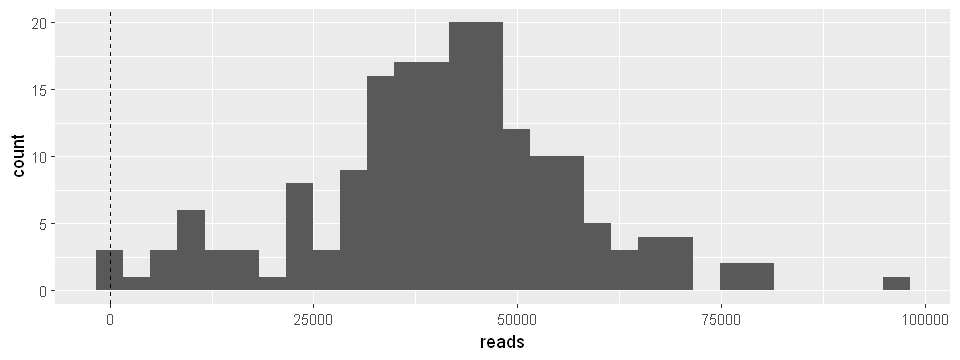

In [7]:
read_counts <- as.data.frame(rowSums(otu_table(ps_raw)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()+
    geom_vline(xintercept=min_reads, linetype='dashed')

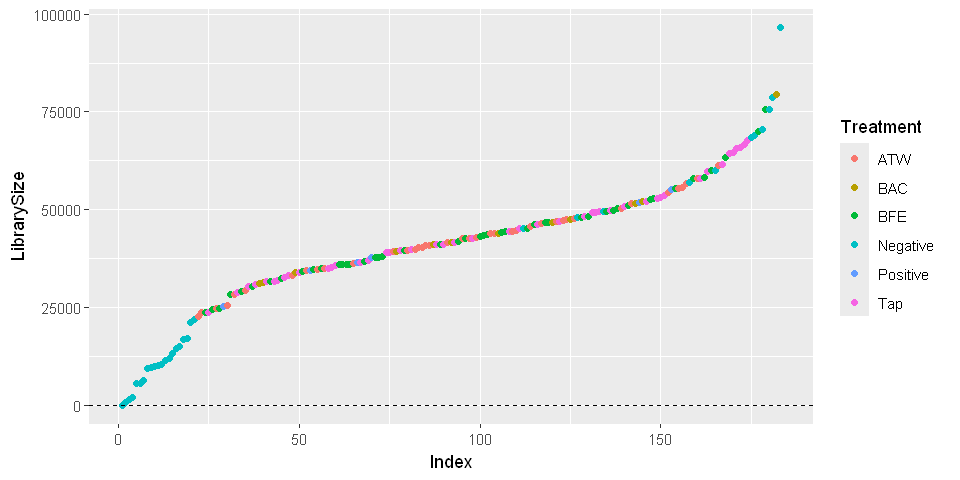

In [8]:
df <- as.data.frame(sample_data(ps_raw)) 
df$LibrarySize <- sample_sums(ps_raw)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=Treatment))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')


# Number of ASVs per sample, including controls

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
"The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_summary()`)."


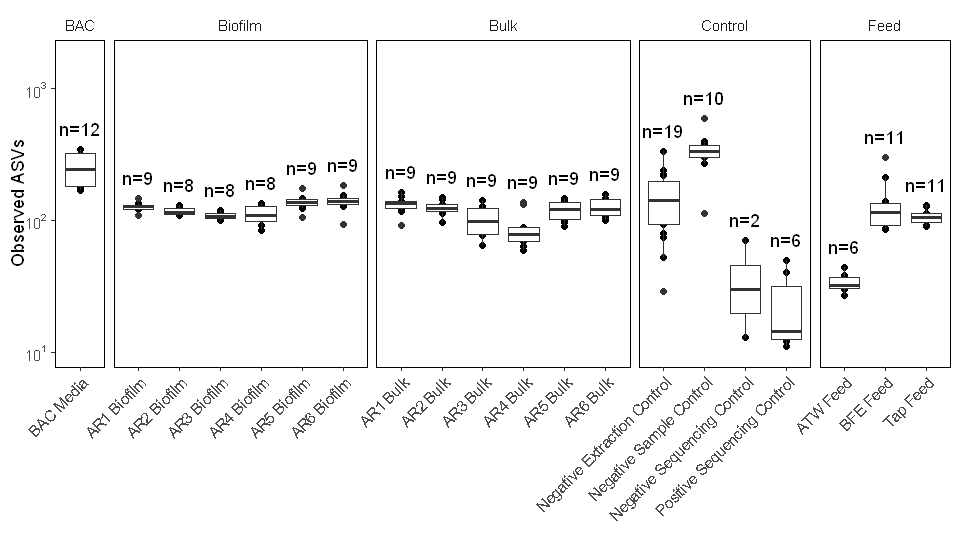

In [9]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 8, repr.plot.height = 4.5)
plot_richness(ps, x="Location", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    facet_grid(.~type, scale="free_x", space="free_x")

# Examine positive controls


## Graph

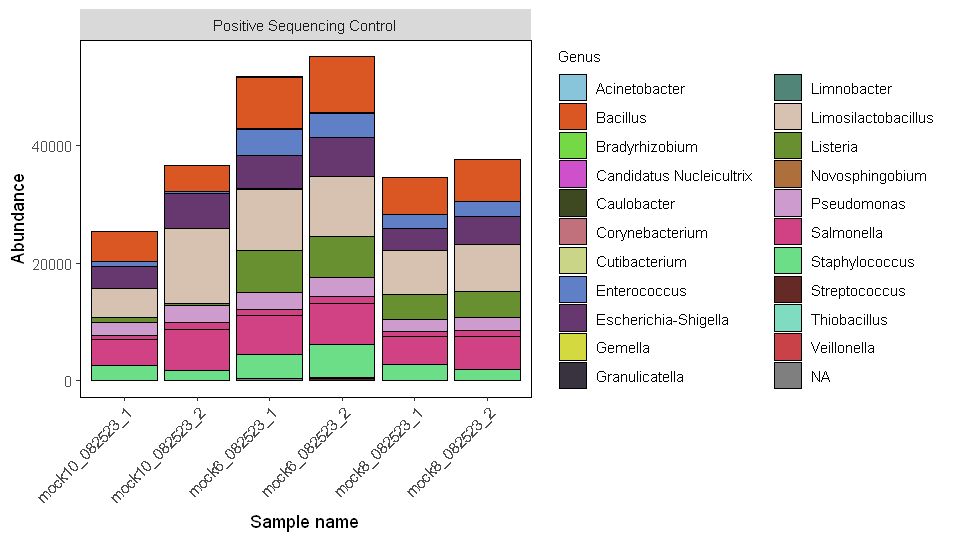

In [7]:
ps_mock <- subset_samples(ps_raw, subset = Treatment %in% c("Positive"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 10, TRUE) #keep only seqs that had reads in mock(s)

options(repr.plot.width = 8, repr.plot.height = 4.5)

plot_bar(ps_mock, x="id_full", fill="Genus") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~Location, scale="free_x", space="free_x")+
ylab("Abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

## Make table of mock sequences

In [8]:
#make table of mock sequences
ps_mock <- subset_samples(ps,  subset = Treatment %in% c("Positive"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)
mock_tax <- as.data.frame(tax_table(ps_mock))
mock_otu <- as.data.frame(otu_table(ps_mock))
mock_otu <- t(mock_otu)
mock_tab <- merge(mock_otu, mock_tax, by=0)
row.names(mock_tab) <- mock_tab$Row.names
                       
mock_tab <- subset(mock_tab, select = -c(Row.names))
mock_tab <- mock_tab[order(-mock_tab$mock10_082523_2), ] # sort in descending order
                    
mock_seqs <- row.names(mock_tab)
mock_seqs <- as.data.frame(refseq(ps_mock))

mock_tab2 <- merge(mock_tab, mock_seqs, by=0, all= TRUE)

row.names(mock_tab2) <- mock_tab2$Row.names
#mock_tab2 <- subset(mock_tab2, select = -c(Row.names))


In [9]:
cat("DADA2 inferred", nrow(mock_seqs), "sample sequences present in the Mock community.\n")

DADA2 inferred 76 sample sequences present in the Mock community.


In [10]:
# load reference sequences for mock controls and compare:

mock.ref <- getSequences('C:/Users/almab/16S/subset/ZymoBIOMICS.STD.refseq.v2/ssrRNAs')

#mock.ref <- as.data.frame(mock.ref)
# identify matches to references, anything else is contamination
match.ref <- sapply(mock_seqs$x, function(x) any(grepl(x, mock.ref)))
match.ref <- as.data.frame(match.ref)
cat("Of those,", sum(match.ref), "were exact matches to the expected reference sequences.\n")

Of those, 9 were exact matches to the expected reference sequences.


In [11]:
mock_tab <- merge(mock_tab2, match.ref, by.x='x', by.y=0)
row.names(mock_tab) <- mock_tab$Row.names
mock_tab <- subset(mock_tab, select = -c(Row.names))
mock_tab <- mock_tab[order(-mock_tab$mock10_082523_2), ] # sort in descending order

In [12]:
mock_taxa <- row.names(mock_tab[1:9,])

# Negative Controls

## Make Taxa Sets

In [13]:
ps_samp <- subset_samples(ps, subset = !(Treatment %in% c("Positive", "Negative")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = Treatment %in% c("Negative"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_samp_blank <- subset_samples(ps, subset = !(Treatment %in% c("Positive")))
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3769 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3769 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3769 reference sequences ]

In [14]:
blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

In [15]:
length(samp_taxa)
length(blank_taxa)
length(intersecting_taxa)
length(samp_only_taxa)
length(blank_only_taxa)

[1] 1972

[1] 2690

[1] 893

[1] 1079

[1] 1797

## Plot intersecting taxa

In [16]:
#for plotting, get intersecting taxa, include mocks
ps_intersecting <- prune_taxa(intersecting_taxa, ps)
ps_intersecting

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 893 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 893 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 893 reference sequences ]

In [17]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))
#
ps_intersecting_perc <- prune_taxa(intersecting_taxa, ps_perc)
ps_intersecting_perc <- filter_taxa(ps_intersecting_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_intersecting_perc_filt5 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 5)), TRUE)
ps_intersecting_perc_filt2 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 2)), TRUE)

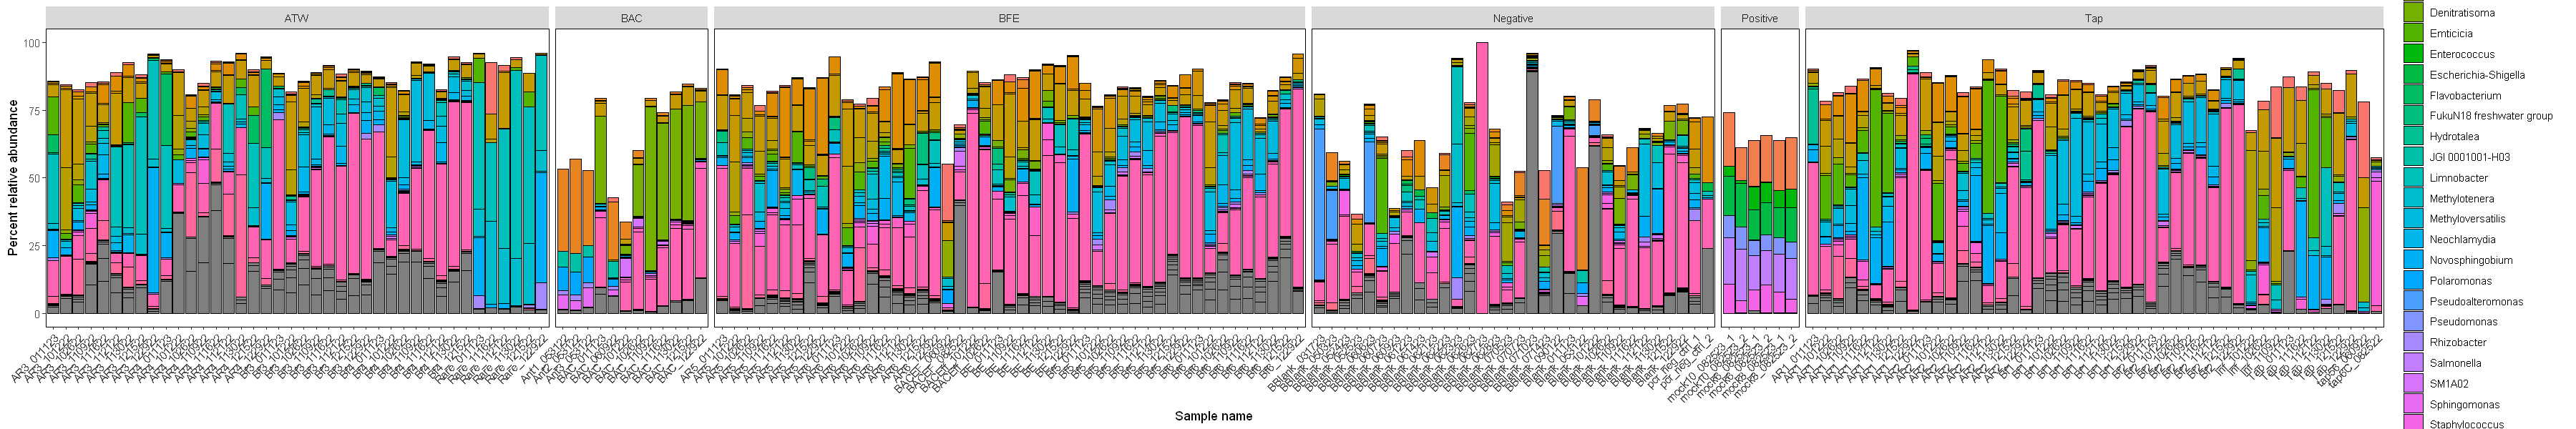

In [18]:
options(repr.plot.width = 30, repr.plot.height = 5)

plot_bar(ps_intersecting_perc_filt5, x="id_full", fill="Genus") +  scale_color_viridis() +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    #facet_wrap(~location_code, nrow=4, scale="free_x")
    facet_grid(.~Treatment, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))
#ggsave('~/data/awtp2_16S/barplot_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=5)

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


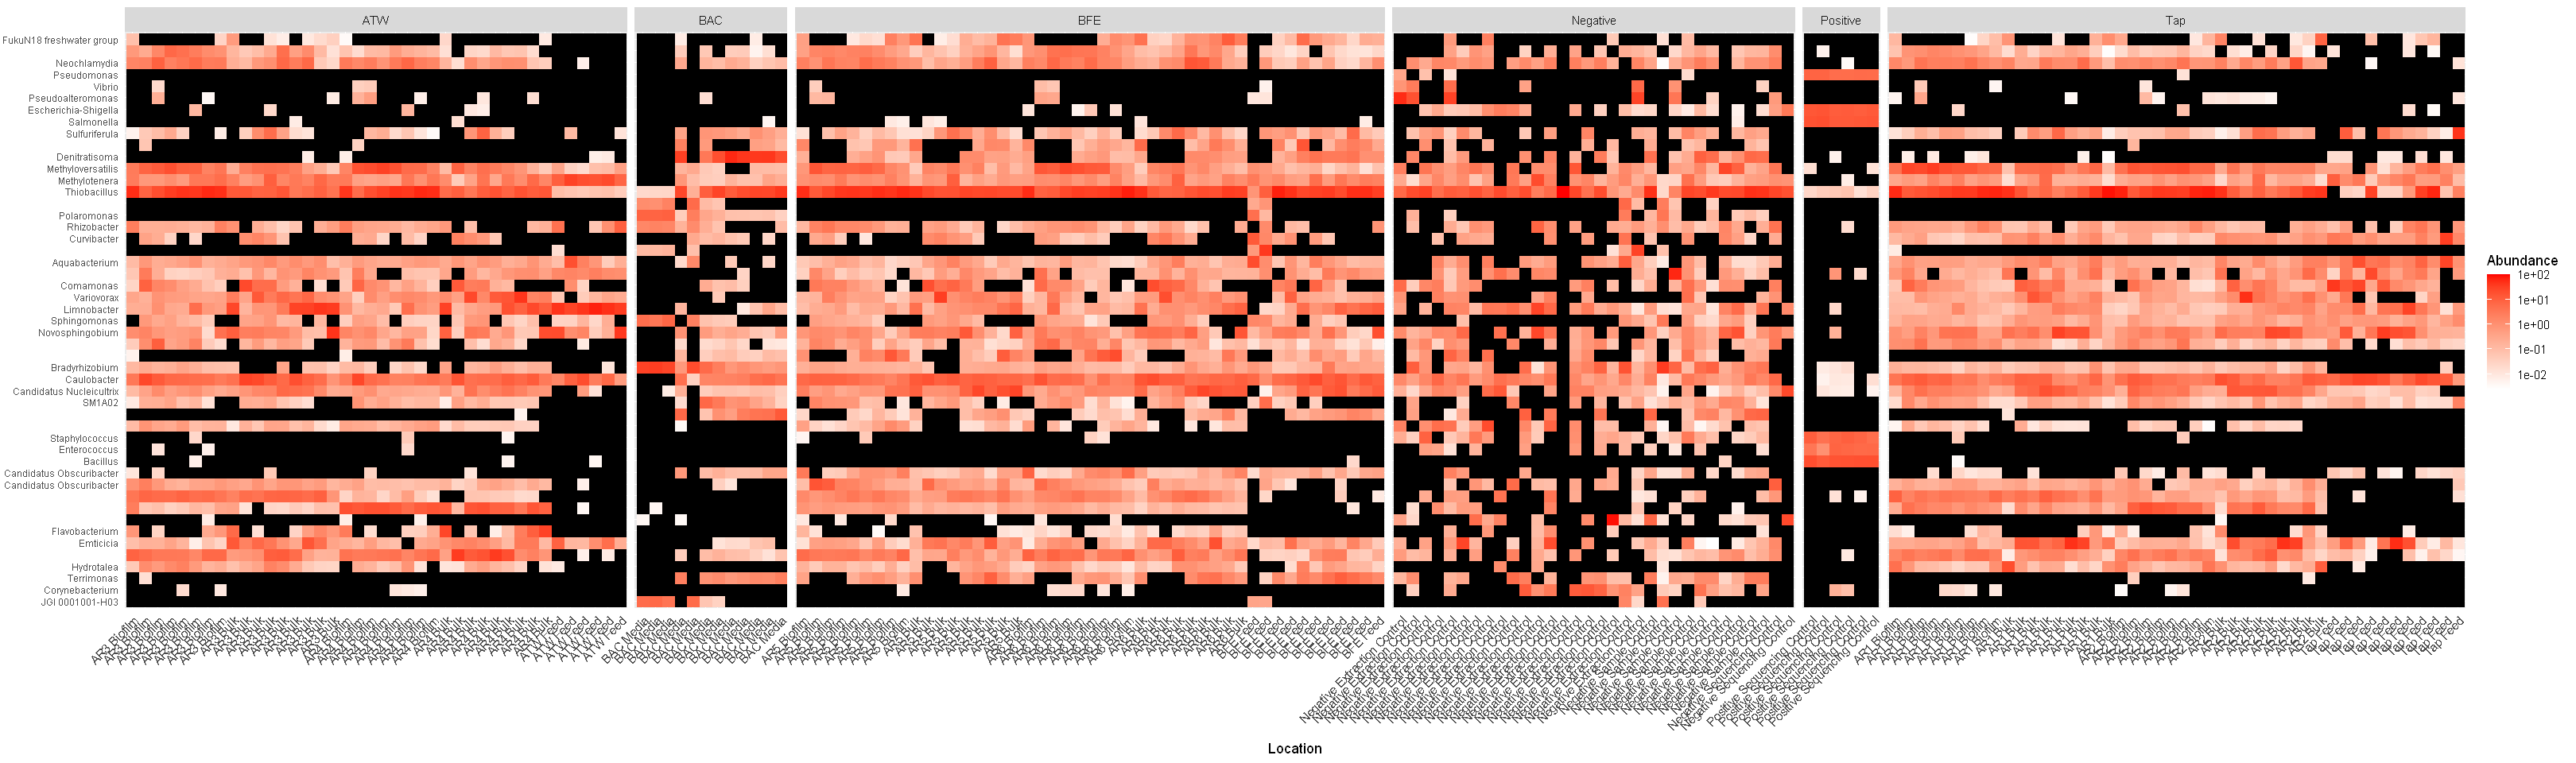

In [19]:
#plot heatmap
options(repr.plot.width = 27, repr.plot.height = 8)
plot_heatmap(ps_intersecting_perc_filt5, taxa.label = "Genus", sample.label = "Location", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=9)

## Cross-contam of positive

In [20]:
ps_mock <- subset_samples(ps_perc,  subset = Treatment %in% c("Positive"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)

ps_samp_blank <- subset_samples(ps_perc, subset = !(Treatment %in% c("Positive")))
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
                      
mocktaxa <- taxa_names(ps_mock)
alltaxa <- taxa_names(ps_samp_blank)
myTaxa <- mocktaxa[mocktaxa %in% alltaxa]


In [21]:
length(myTaxa)

[1] 58

In [22]:
ps_mock_in_all_perc <- prune_taxa(mock_taxa, ps_perc)


Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


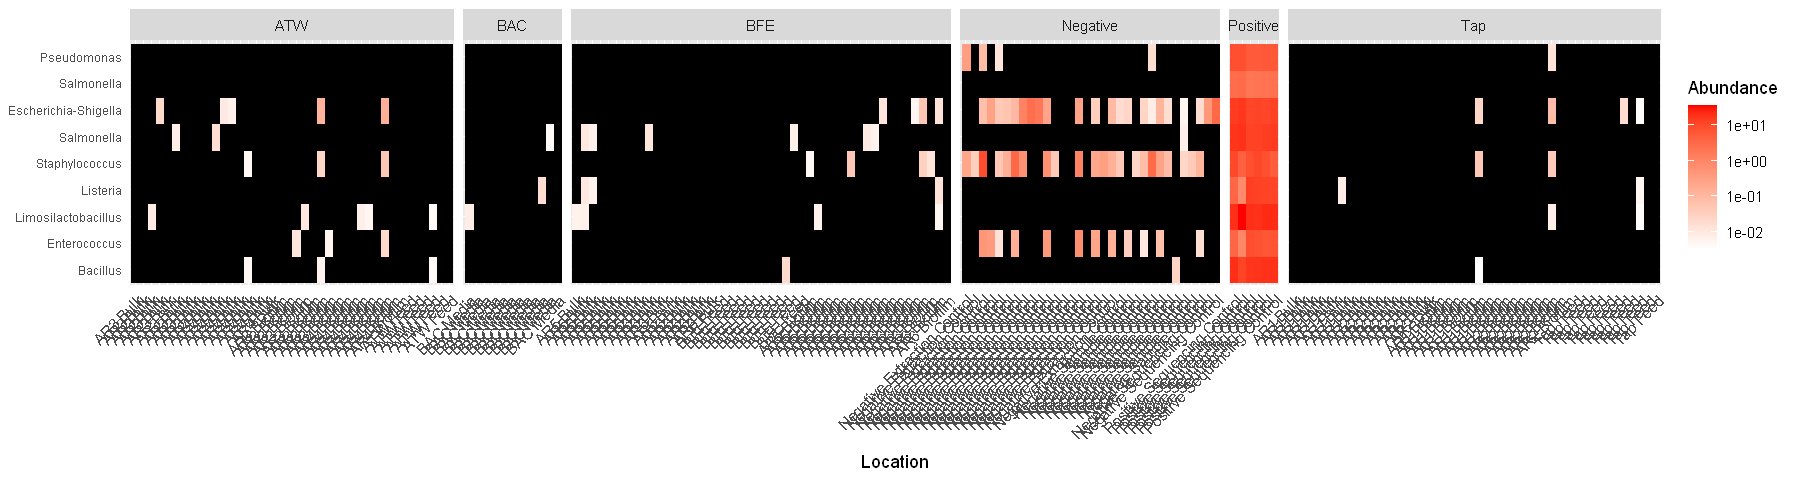

In [23]:
#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 4)
plot_heatmap(ps_mock_in_all_perc, taxa.label = "Genus", sample.label = "Location", sample.order = "Treatment", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_mock_in_all.png', device='png', width=20, height=4)

# Decontamination

In [24]:
length(blank_taxa)
length(samp_taxa)
length(intersecting_taxa)

[1] 2690

[1] 1972

[1] 893

In [25]:
ps_samp_blank <- subset_samples(ps, subset = !(Treatment %in% c("Positive")))
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3769 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3769 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3769 reference sequences ]

In [26]:
#for decontamination: Get all taxa found in samples, include blanks in ps object.
#ps_samp_blank_for_decontam <- prune_taxa(samp_taxa, ps_samp_blank)
ps_samp_blank_for_decontam <- ps_samp_blank
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3769 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3769 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3769 reference sequences ]

## Remove mock taxa from dataset 

In [27]:
allTaxa = taxa_names(ps_samp_blank_for_decontam)
allTaxa_minus_mock <- allTaxa[!(allTaxa %in% mock_taxa)]
ps_samp_blank_for_decontam <- prune_taxa(allTaxa_minus_mock, ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3761 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3761 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3761 reference sequences ]

## Remove Any PCR negative control that is contaminated with mock taxa

In [44]:
# not applicable

## Redefine intersecting taxa (found in blanks and samples) now that samples have been curated

In [28]:
ps_samp <- subset_samples(ps_samp_blank_for_decontam, subset = !(Treatment %in% c("Negative","Positive" )))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = (Treatment %in% c("Negative") ))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#For only low library size blanks:
ps_samp_blank <- subset_samples(ps_samp_blank_for_decontam, subset = (sample_or_control %in% c("Sample" )) | (Treatment %in% c("Negative") ))
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE)

blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
length(intersecting_taxa)

[1] 887

## Identify Highly Contmaminated Blanks

In [477]:
# Higly contaminated blanks are removed because it is impossible to tell if 
# amplified signal in blanks contaminated samples or was contaminated by samples.
# Thus only signal more prevalent in blanks will be removed.
#df <- as.data.frame(sample_data(ps_samp_blank_for_decontam)) # Put sample_data into a ggplot-friendly data.frame
#df$LibrarySize <- sample_sums(ps_samp_blank_for_decontam)
#df <- df[order(df$LibrarySize),]
#df$Index <- seq(nrow(df))
#low <- row.names(df[df$LibrarySize  < 22000,])  

In [478]:
#ps_samp <- subset_samples(ps_samp_blank_for_decontam, subset = !(Treatment %in% c("Negative","Positive" )))
#ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = (Treatment %in% c("Negative") & row.names(sample_data(ps_samp_blank_for_decontam)) %in% low))
#ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#For only low library size blanks:
#ps_samp_blank <- subset_samples(ps_samp_blank_for_decontam, subset = (sample_or_control %in% c("Sample" )) | (Treatment %in% c("Negative") & row.names(sample_data(ps_samp_blank_for_decontam)) %in% low))
#ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE)

#blank_taxa <- taxa_names(ps_blank)
#samp_taxa <- taxa_names(ps_samp)
#samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)


In [479]:
length(samp_taxa)
length(samp_only_taxa)

[1] 1964

[1] 1077

In [29]:
ps_samp_blank_for_decontam <- ps_samp_blank
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3761 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3761 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3761 reference sequences ]

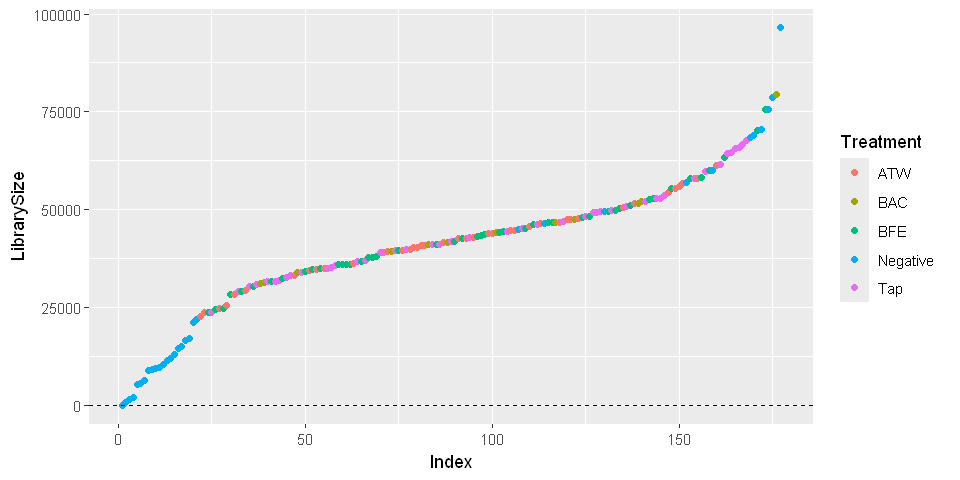

In [30]:
df <- as.data.frame(sample_data(ps_samp_blank_for_decontam)) 
df$LibrarySize <- sample_sums(ps_samp_blank_for_decontam)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=Treatment))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')


## DESeq2-guided subtractive decontamination method

In [31]:
#set factor levels so "control" comes first
sample_data(ps_samp_blank_for_decontam)$sample_or_control <- factor(sample_data(ps_samp_blank_for_decontam)$sample_or_control, levels=c("Control", "Sample"))

In [32]:
# Remove samples with 0 taxa
ps_samp_blank_for_decontam <- prune_samples(sample_sums(ps_samp_blank_for_decontam)>0, ps_samp_blank_for_decontam)

In [33]:
#run DESeq on all samples vs blanks
# following: https://bioconductor.org/packages/devel/bioc/vignettes/phyloseq/inst/doc/phyloseq-mixture-models.html

diagdds_full = phyloseq_to_deseq2(ps_samp_blank_for_decontam, ~ sample_or_control)

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds_full), 1, gm_mean)
diagdds_full = estimateSizeFactors(diagdds_full, geoMeans = geoMeans)
diagdds_full = DESeq(diagdds_full, test="Wald", fitType="local")

res_full = results(diagdds_full, cooksCutoff = FALSE)
res_full = res_full[order(res_full$padj, na.last=NA), ]

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1309 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


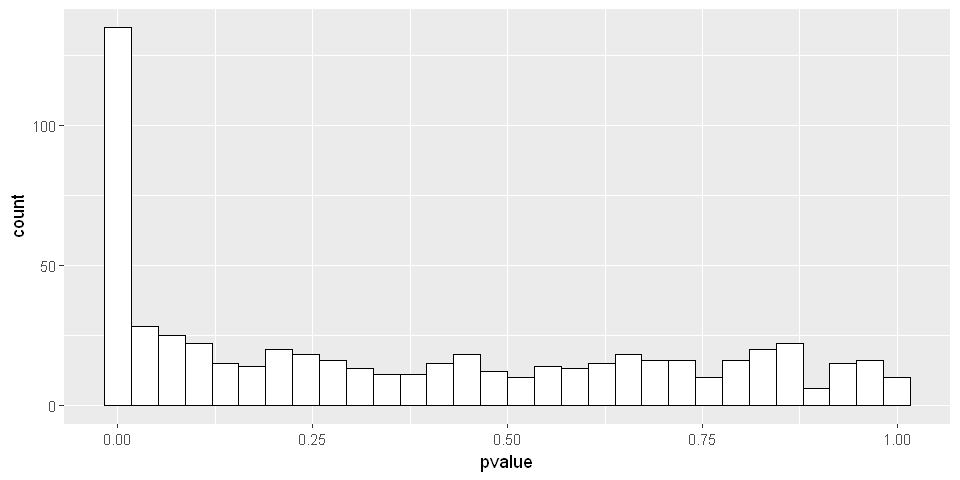

In [34]:
ggplot(as.data.frame(res_full), aes(x=pvalue)) + 
  geom_histogram(color="black", fill="white")


In [35]:
alpha = 0.01
sigtab_full = res_full[(res_full$padj < alpha), ]
sigtab_full = cbind(as(sigtab_full, "data.frame"), as(tax_table(ps_samp_blank_for_decontam)[rownames(sigtab_full), ], "matrix"))

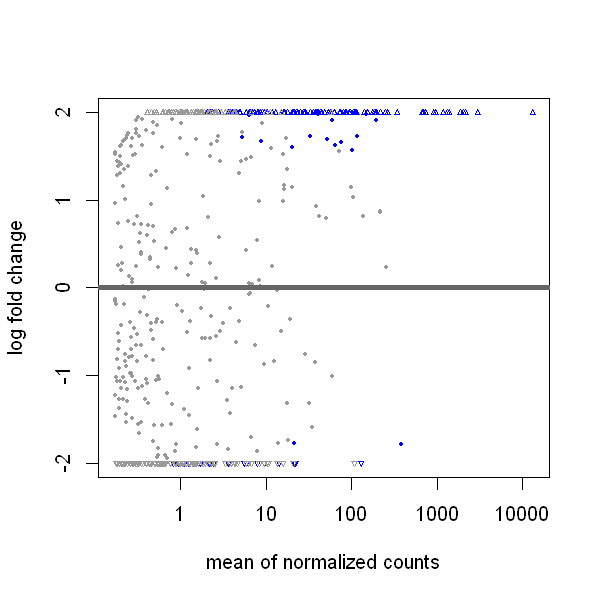

In [36]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res_full, ylim=c(-2,2))

No significant results were found for enrichment in control vs. sample using deseq at alpha 0.01...

In [37]:
posigtab = sigtab_full[sigtab_full[, "log2FoldChange"] > 0, ]
posigtab = posigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


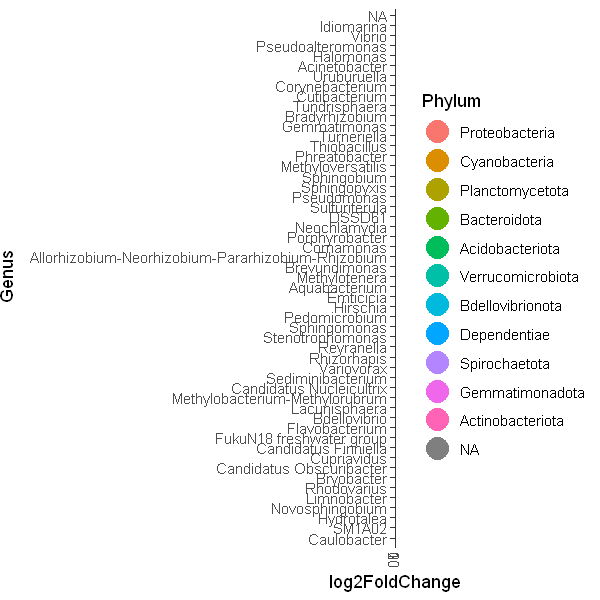

In [38]:
theme_set(theme_bw())
sigtabgen = subset(sigtab_full)
# Phylum order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Phylum = factor(as.character(sigtabgen$Phylum), levels=names(x))
# Genus order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels=names(x))
ggplot(sigtabgen, aes(y=Genus, x=log2FoldChange, color=Phylum)) + 
  geom_vline(xintercept = 0.0, color = "gray", size = 0.5) +
  geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [39]:
significant_taxa_full <- row.names(sigtab_full[sigtab_full$log2FoldChange > 0,]) #what is significantly enriched in samples over blanks?

In [40]:
length(significant_taxa_full)

[1] 82

### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [41]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks_full <- intersect(intersecting_taxa, significant_taxa_full)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples_full <- setdiff(intersecting_taxa, significant_taxa_full)
length(samples_over_blanks_full)
length(blanks_over_samples_full)

[1] 71

[1] 816

### Heatmaps of taxa to keep and taxa to remove


In [42]:
# normalize to percent
ps_perc <- transform_sample_counts(ps_samp_blank_for_decontam, function(OTU) 100*OTU/sum(OTU))


Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


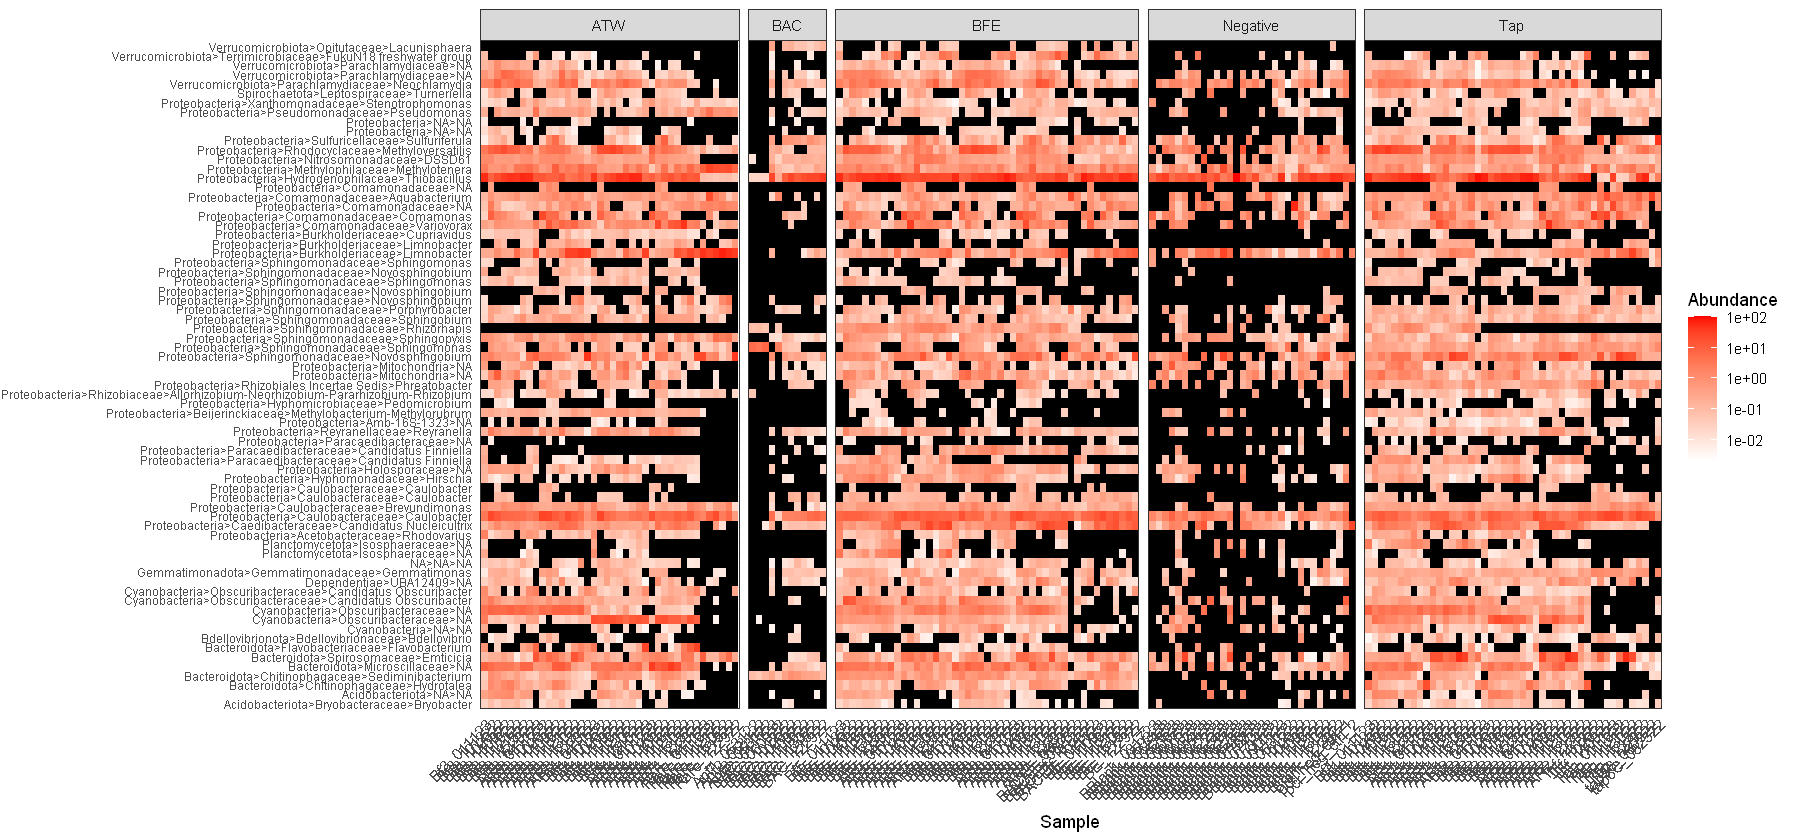

In [43]:
ps_perc_samples_over_blanks_full <- prune_taxa(samples_over_blanks_full, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_samples_over_blanks_full, taxa.label = "combined", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=4)

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-4 transformation introduced infinite values."


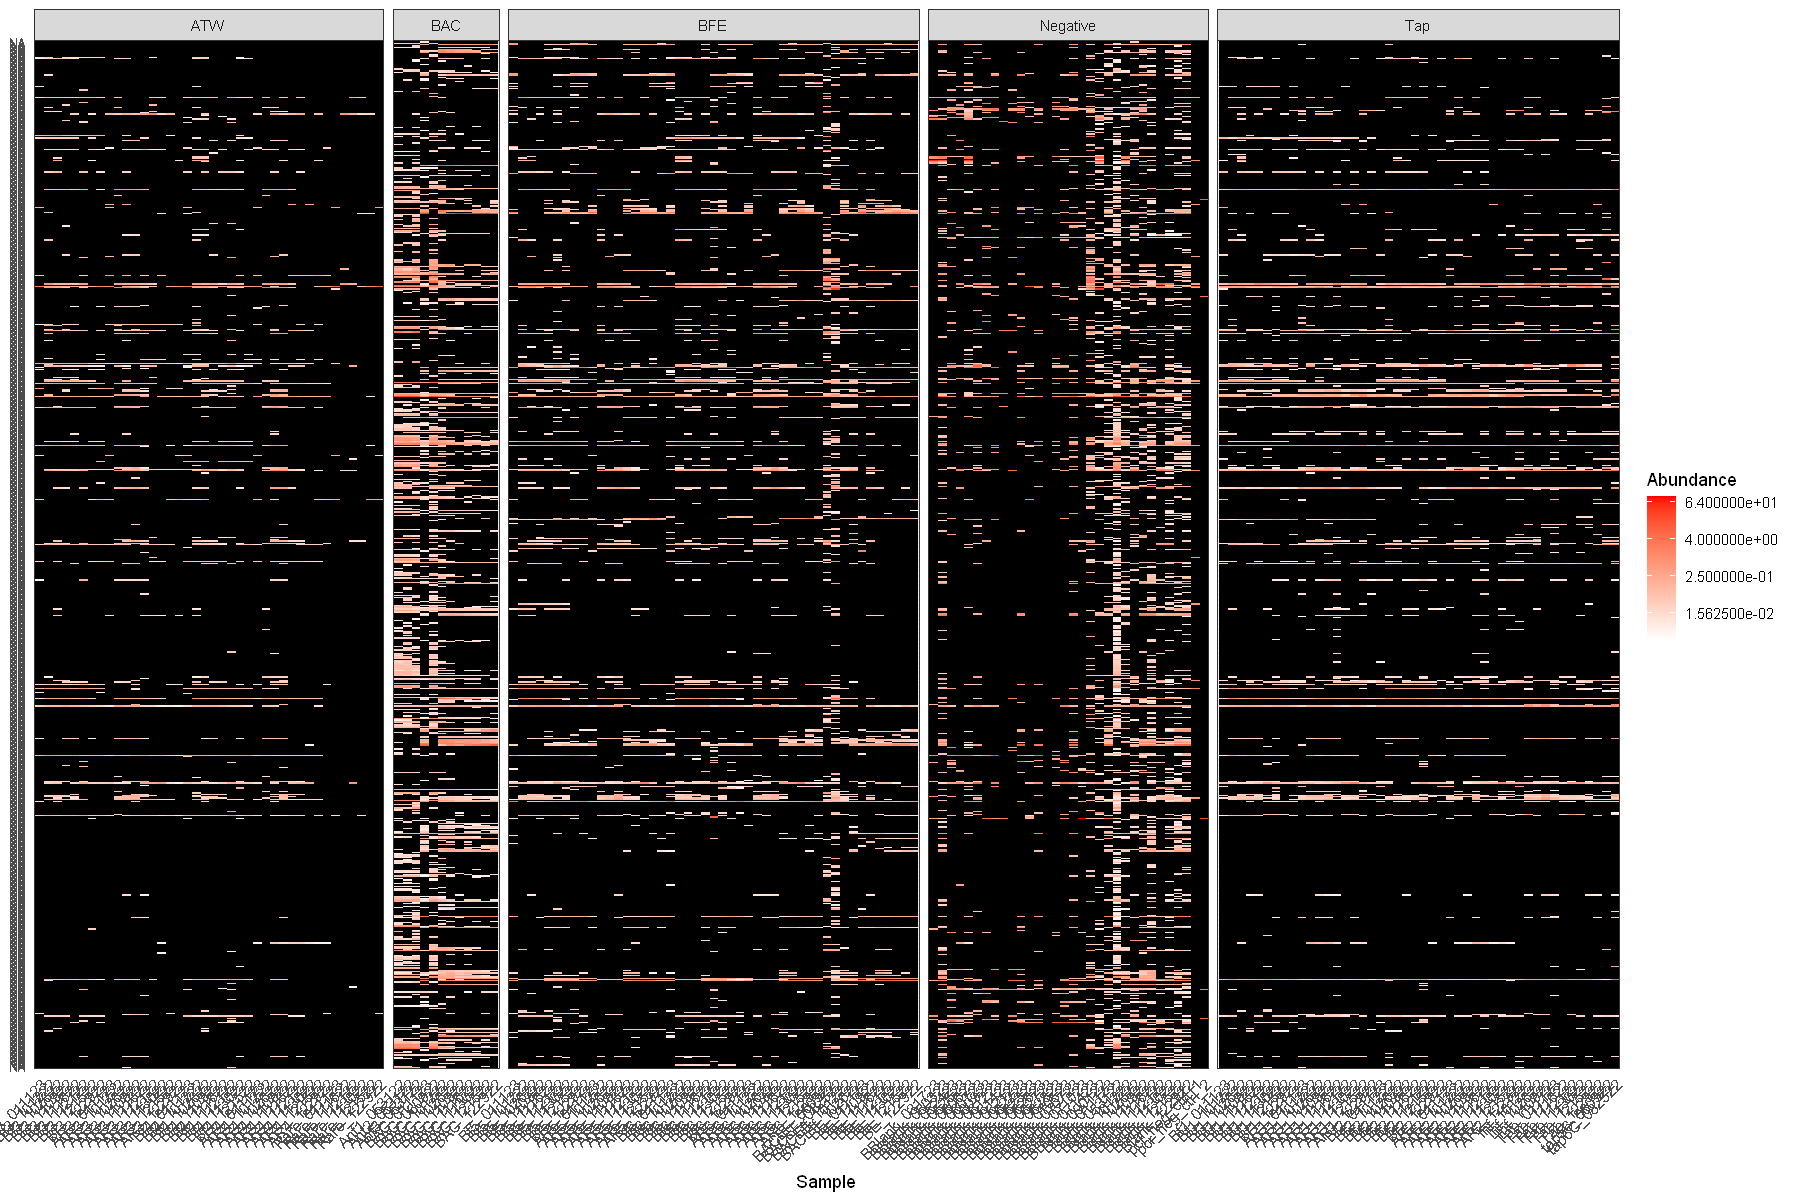

In [44]:
ps_perc_blanks_over_samples_full <- prune_taxa(blanks_over_samples_full, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 10)
plot_heatmap(ps_perc_blanks_over_samples_full, taxa.label = "combined", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black")+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_blanks_over_samples', device='png', width=25, height=15)

Does not do a great job of differentiating the sample enrichment vs blank contamination. Not using this this method.

### Combine to get taxa from sample-only and taxa significant by DESeq, convert to relative abundance of remaining reads

In [45]:
ps_clean <- prune_taxa(taxa=union(significant_taxa_full, samp_only_taxa), ps)
sample_data(ps_clean)$filtered_readcounts <- sample_sums(ps_clean)
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1148 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1148 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1148 reference sequences ]

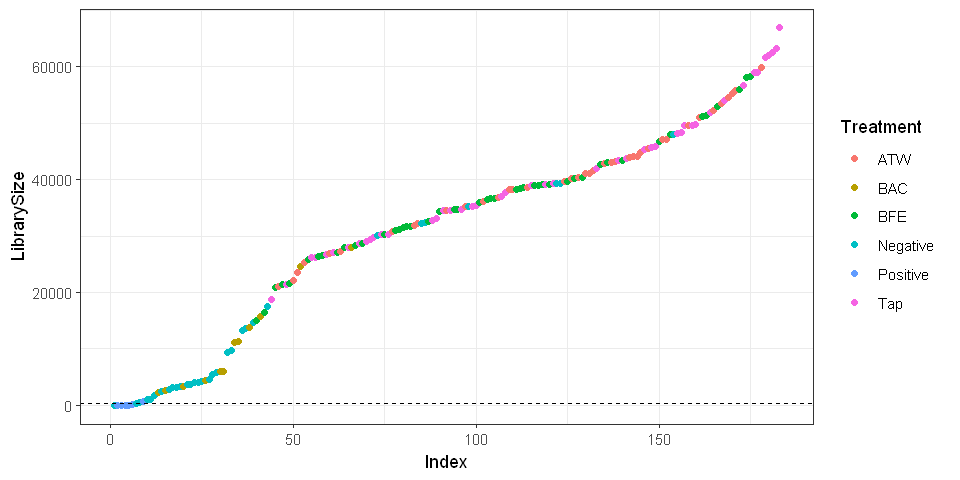

In [46]:
min_reads <- 300
df <- as.data.frame(sample_data(ps_clean)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_clean)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=Treatment))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')

In [186]:
ps_clean_filt <- prune_samples(sample_sums(ps_clean)>=5, ps_clean) #remove samples now with too few reads
ps_clean_filt <- filter_taxa(ps_clean_filt, filterfun(kOverA(1, 0)), TRUE)
ps_clean_perc <- transform_sample_counts(ps_clean_filt, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_clean
ps_clean_filt
                                              
saveRDS(ps_clean_filt, "C:/Users/almab/16S/ps_clean_filt.rds")
#saveRDS(ps_clean_perc, "~/data/awtp2_16S/ps_clean_perc.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1540 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1540 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1540 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1540 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1540 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1540 reference sequences ]

## Trying DESeq2 Method on individual sample types

In [47]:
# Remove samples with 0 taxa
ps_samp_blank_for_decontam <- prune_samples(sample_sums(ps_samp_blank_for_decontam)>0, ps_samp_blank_for_decontam)

In [48]:
locations <- as.data.frame(table(sample_data(ps_samp_blank_for_decontam)$Location))
colnames(locations)=c('Location', 'count')
#locations[location$count>=]

In [51]:
#all sample types with >=3 samples
Tap_bulk <- c('AR1 Bulk', 'AR2 Bulk','AR1 Biofilm', 'AR2 Biofilm', 'Tap Feed')
#Tap_bf <- c('AR1 Biofilm', 'AR2 Biofilm')
ATW_bulk <- c('AR3 Bulk', 'AR4 Bulk','AR3 Biofilm', 'AR4 Biofilm','ATW Feed')
#ATW_bf <- c('AR3 Biofilm', 'AR4 Biofilm')
BFE_bulk <- c('AR5 Bulk', 'AR6 Bulk','AR5 Biofilm', 'AR6 Biofilm','BFE Feed')
#BFE_bf <- c('AR5 Biofilm', 'AR6 Biofilm')
BAC <- 'BAC Media'
#Feeds <- c('Tap Feed', 'ATW Feed', 'BFE Feed')

types <- list(Tap_bulk, ATW_bulk,  BFE_bulk,  BAC)
types

[[1]]
[1] "AR1 Bulk"    "AR2 Bulk"    "AR1 Biofilm" "AR2 Biofilm" "Tap Feed"   

[[2]]
[1] "AR3 Bulk"    "AR4 Bulk"    "AR3 Biofilm" "AR4 Biofilm" "ATW Feed"   

[[3]]
[1] "AR5 Bulk"    "AR6 Bulk"    "AR5 Biofilm" "AR6 Biofilm" "BFE Feed"   

[[4]]
[1] "BAC Media"

In [52]:
significant_taxa <- c()
for (i in types){
    ps_subset_blank <- subset_samples(ps_samp_blank_for_decontam, subset = Location %in% c(i, c('Negative Sample Control','Negative Extraction Control', 'Negative Sequencing Control')))

    #run DESeq 
    diagdds = phyloseq_to_deseq2(ps_subset_blank, ~ sample_or_control)

    # calculate geometric means prior to estimate size factors
    gm_mean = function(x, na.rm=TRUE){
      exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
    }
    geoMeans = apply(counts(diagdds), 1, gm_mean)
    diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
    diagdds = DESeq(diagdds, test="Wald", fitType="local")

    res = results(diagdds, cooksCutoff = FALSE)
    res = res[order(res$padj, na.last=NA), ]
    alpha = 0.01
    sigtab = res[(res$padj < alpha), ]
    sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_subset_blank)[rownames(sigtab), ], "matrix"))
    significant_taxa_subset <- row.names(sigtab[sigtab$log2FoldChange > 0,])
    significant_taxa <- c(significant_taxa, significant_taxa_subset)
}

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1150 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1162 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [53]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples <- setdiff(intersecting_taxa, significant_taxa)
length(samples_over_blanks)
length(blanks_over_samples)

[1] 106

[1] 781

In [54]:
length(setdiff(samples_over_blanks, samples_over_blanks_full))

[1] 40

**This method identified the 106 of 71 significantly enriched taxa (samples_over_blanks) that were found when using the entire dataset for samples vs control.**

**This method also identified 40 additional significantly enriched taxa that were enriched in specific sample types over blanks.**

### Heatmaps of taxa to keep and taxa to remove

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


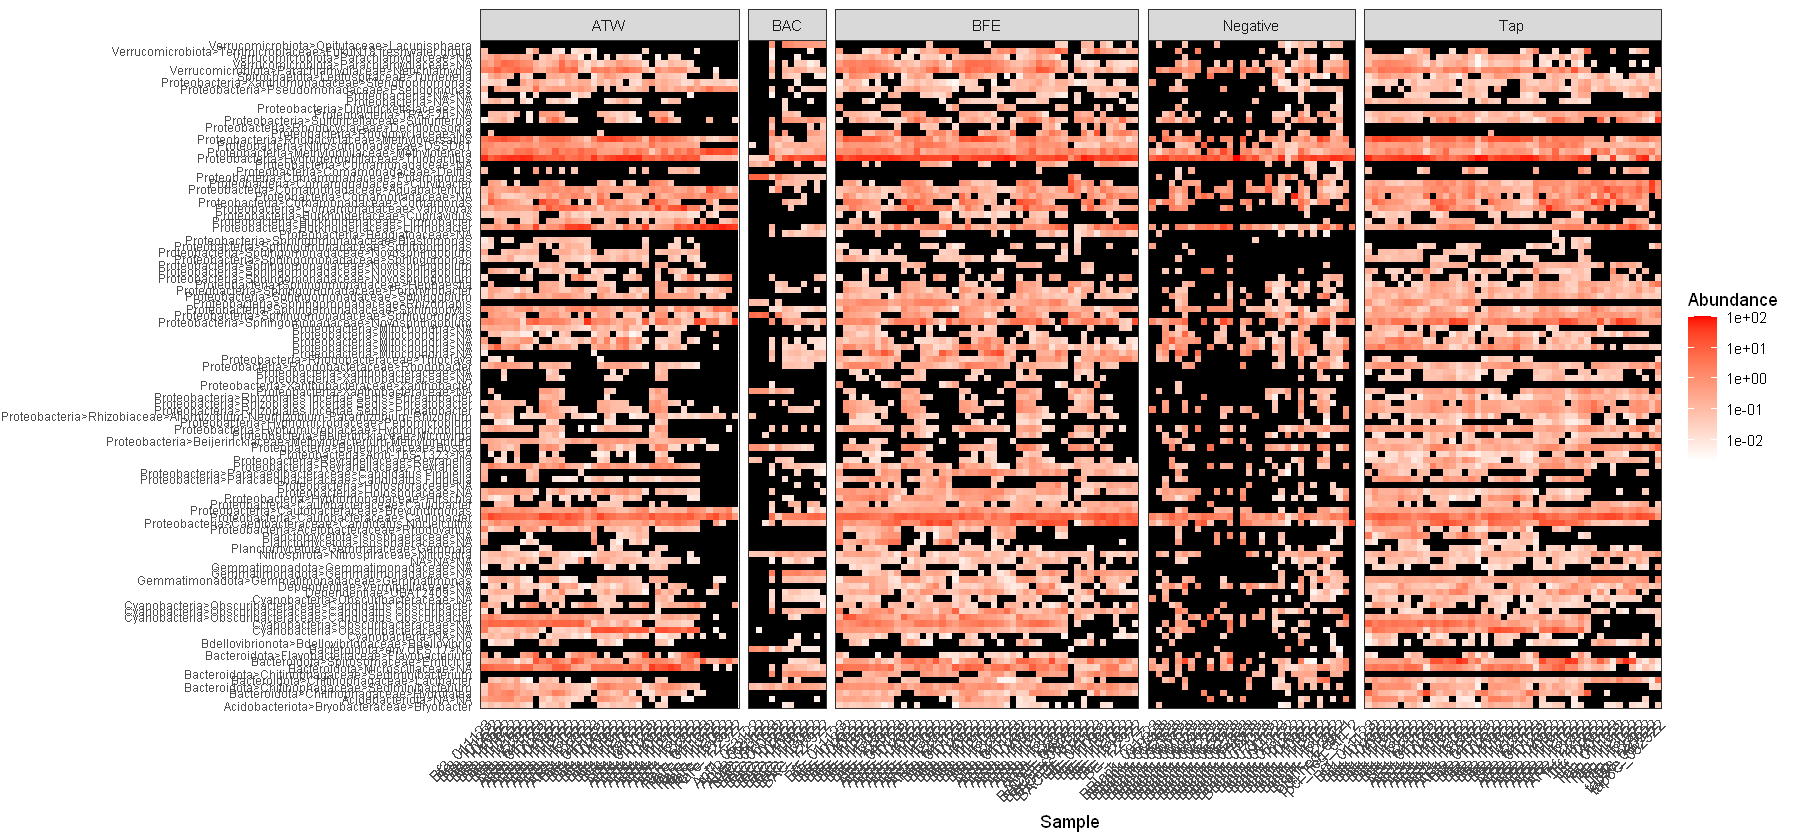

In [55]:
ps_perc_samples_over_blanks <- prune_taxa(samples_over_blanks, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_samples_over_blanks, taxa.label = "combined", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=7)

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


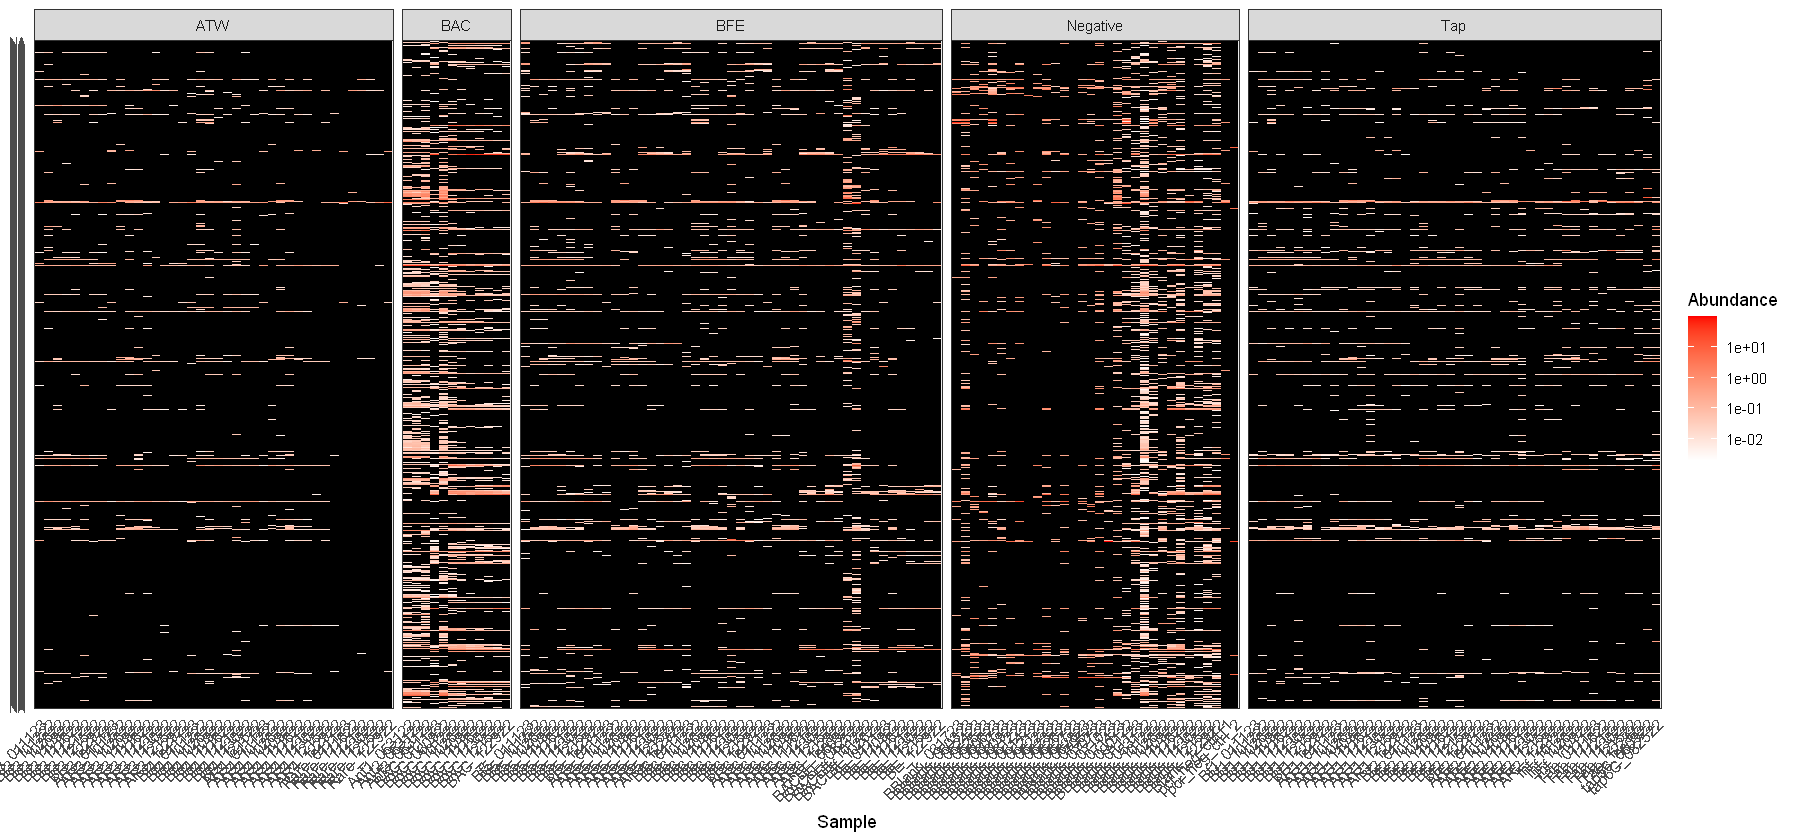

In [56]:
ps_perc_blanks_over_samples <- prune_taxa(blanks_over_samples, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_blanks_over_samples, taxa.label = "combined", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=7)

## Decontam frequency method


In [57]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3787 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3787 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3787 reference sequences ]

In [58]:
sample_data(ps)$filtered_readcounts <- sample_sums(ps)


`geom_smooth()` using formula = 'y ~ x'


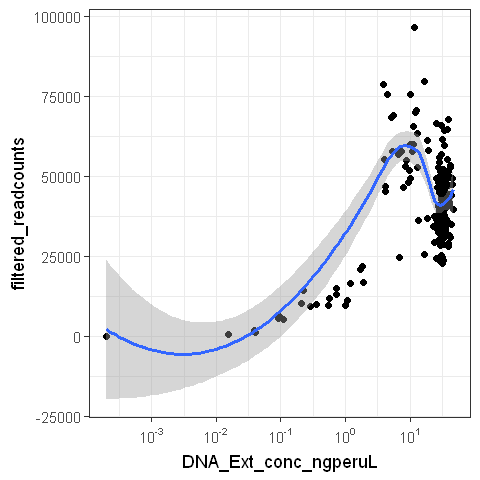

In [59]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(sample_data(ps), aes(x=DNA_Ext_conc_ngperuL, y=filtered_readcounts))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x))) + 
    geom_smooth(method = loess) 
    #scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))


In [60]:
contamdf.freq <- isContaminant(ps_samp, method="frequency", conc="DNA_Ext_conc_ngperuL", threshold = .1)

In [61]:
table(contamdf.freq$contaminant)
head(which(contamdf.freq$contaminant))


FALSE  TRUE 
 1958     6 

[1]  510  730  878  937 1328 1418

In [62]:
decontam_freq_contams <- row.names(contamdf.freq[contamdf.freq$contaminant==TRUE,])

In [64]:
decontam_freq_intersect <- intersect(decontam_freq_contams, intersecting_taxa)
decontam_freq_intersect

[1] "ASV929"  "ASV1249"

**The decontam frequency method identified 2 ASVs that were part of the intersection of negative controls and samples.**

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


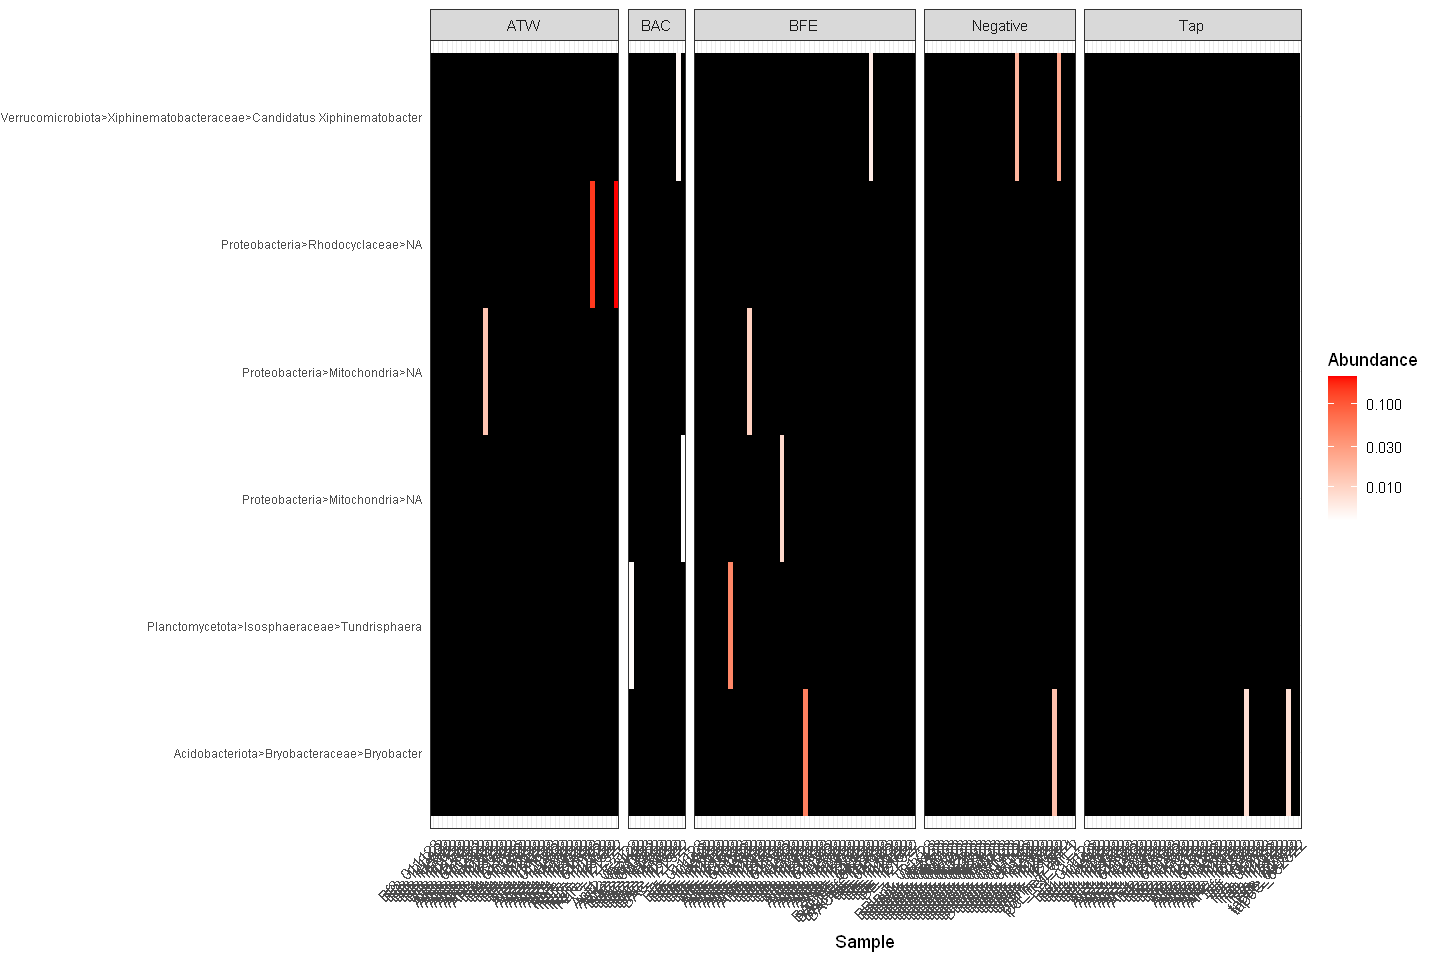

In [65]:
ps_decontam_freq_contams <- prune_taxa(decontam_freq_contams, ps_perc)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_freq_contams, taxa.label = "combined",  sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_contams.png', device='png', width=20, height=9)

## Decontam prevalence method


### Using all blanks was most comprehensive to identify contaminants without flagging any ASVs enriched in samples. 

In [133]:
ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = Location %in% c('Negative Sample Control','Negative Extraction Control', 'Negative Sequencing Control'))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2684 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 2684 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 2684 reference sequences ]

In [134]:
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3761 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3761 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3761 reference sequences ]

In [135]:
samp_names <- sample_names(ps_samp)
#ext_blanks <- sample_names(subset_samples(ps_samp_blank_for_decontam, subset = (Location %in% c('Negative Extraction Control'))))
#field_blanks <- sample_names(subset_samples(ps_samp_blank_for_decontam, subset = (Location %in% c('Negative Sample Control'))))
#drop 2 inconsistent field blanks: EXP_0_field_bulk_10_A_19 and EXP_0_field_bulk_9_NA_19 from field_blanks c('SD001', 'SD117')
ps_samp_blank_for_decontam.field <- prune_samples(c(samp_names, sample_names(ps_blank)), ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam.field <- filter_taxa(ps_samp_blank_for_decontam.field, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank_for_decontam.field

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3761 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3761 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3761 reference sequences ]

In [136]:
sample_data(ps_samp_blank_for_decontam.field)$is.neg <- sample_data(ps_samp_blank_for_decontam.field)$sample_or_control == "Control"
contamdf.prev <- isContaminant(ps_samp_blank_for_decontam.field, method="prevalence", neg="is.neg", threshold = .1)
table(contamdf.prev$contaminant)


FALSE  TRUE 
 3275   486 

In [137]:
decontam_prev_contams <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


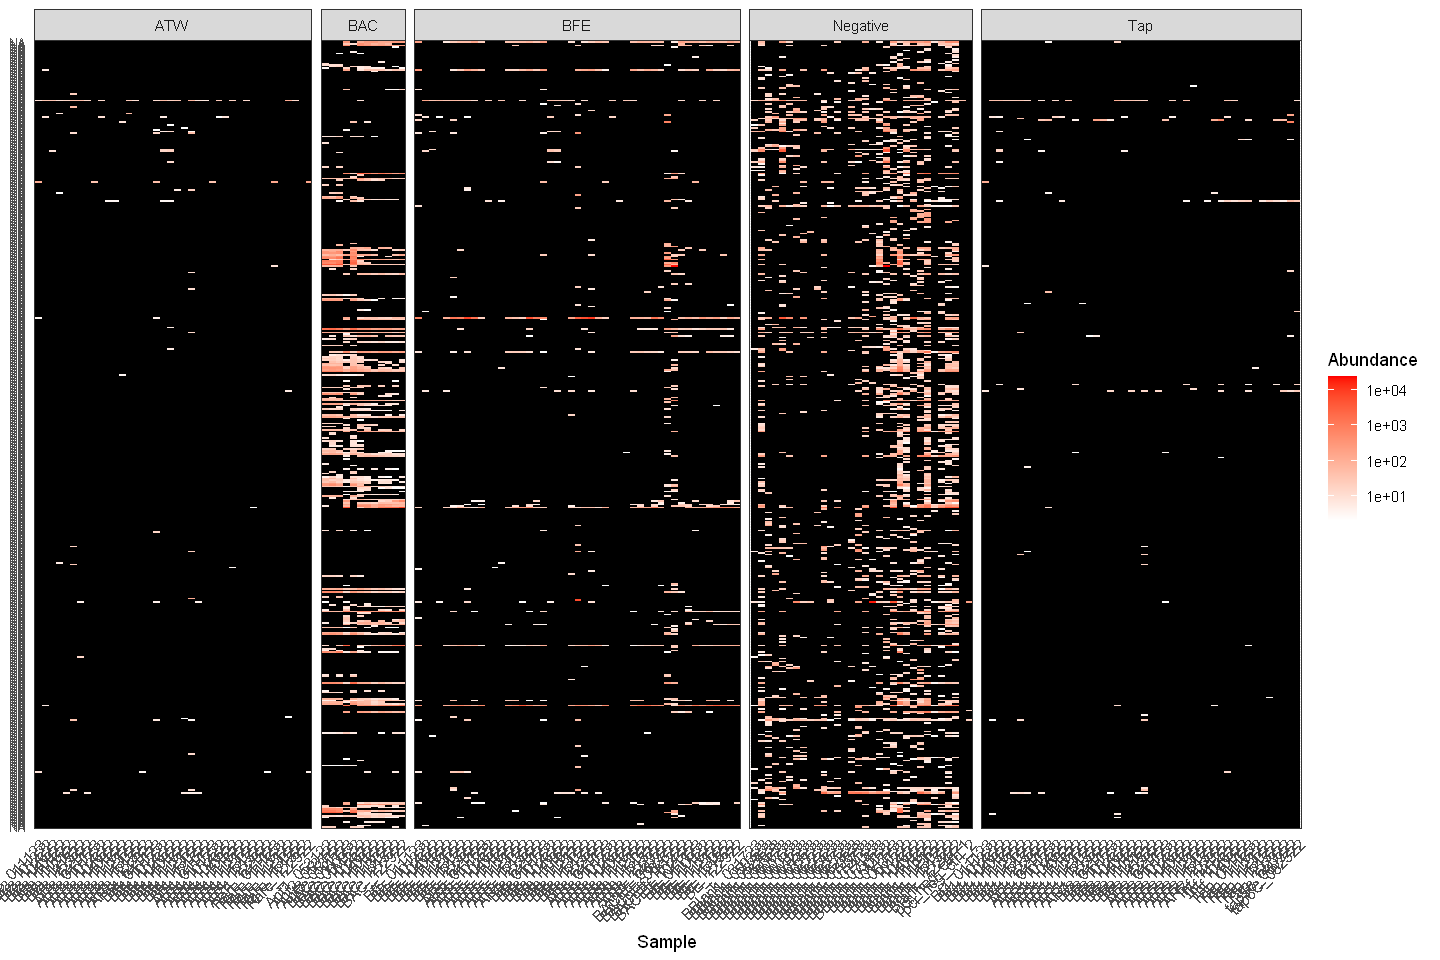

In [138]:
ps_decontam_prev_contams <- prune_taxa(decontam_prev_contams, ps_samp_blank_for_decontam.field)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams, taxa.label = "combined", sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_prev_contams.png', device='png', width=20, height=9)

In [139]:
length(intersect(decontam_prev_contams, samples_over_blanks))

[1] 4

In [140]:
length(intersect(decontam_prev_contams, blanks_over_samples))
length(blanks_over_samples)

[1] 277

[1] 781

**The `decontam` prevalence method identified as contaminants 277 of the 781 taxa removed by DESeq2-guided subtractive decontamination.**

**Prevalence won't work perfectly because it will miss contaminants that are present in ALL samples, so the best approach would be to combine frequency and prevalence.**

## Combining prevalence and frequency


Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


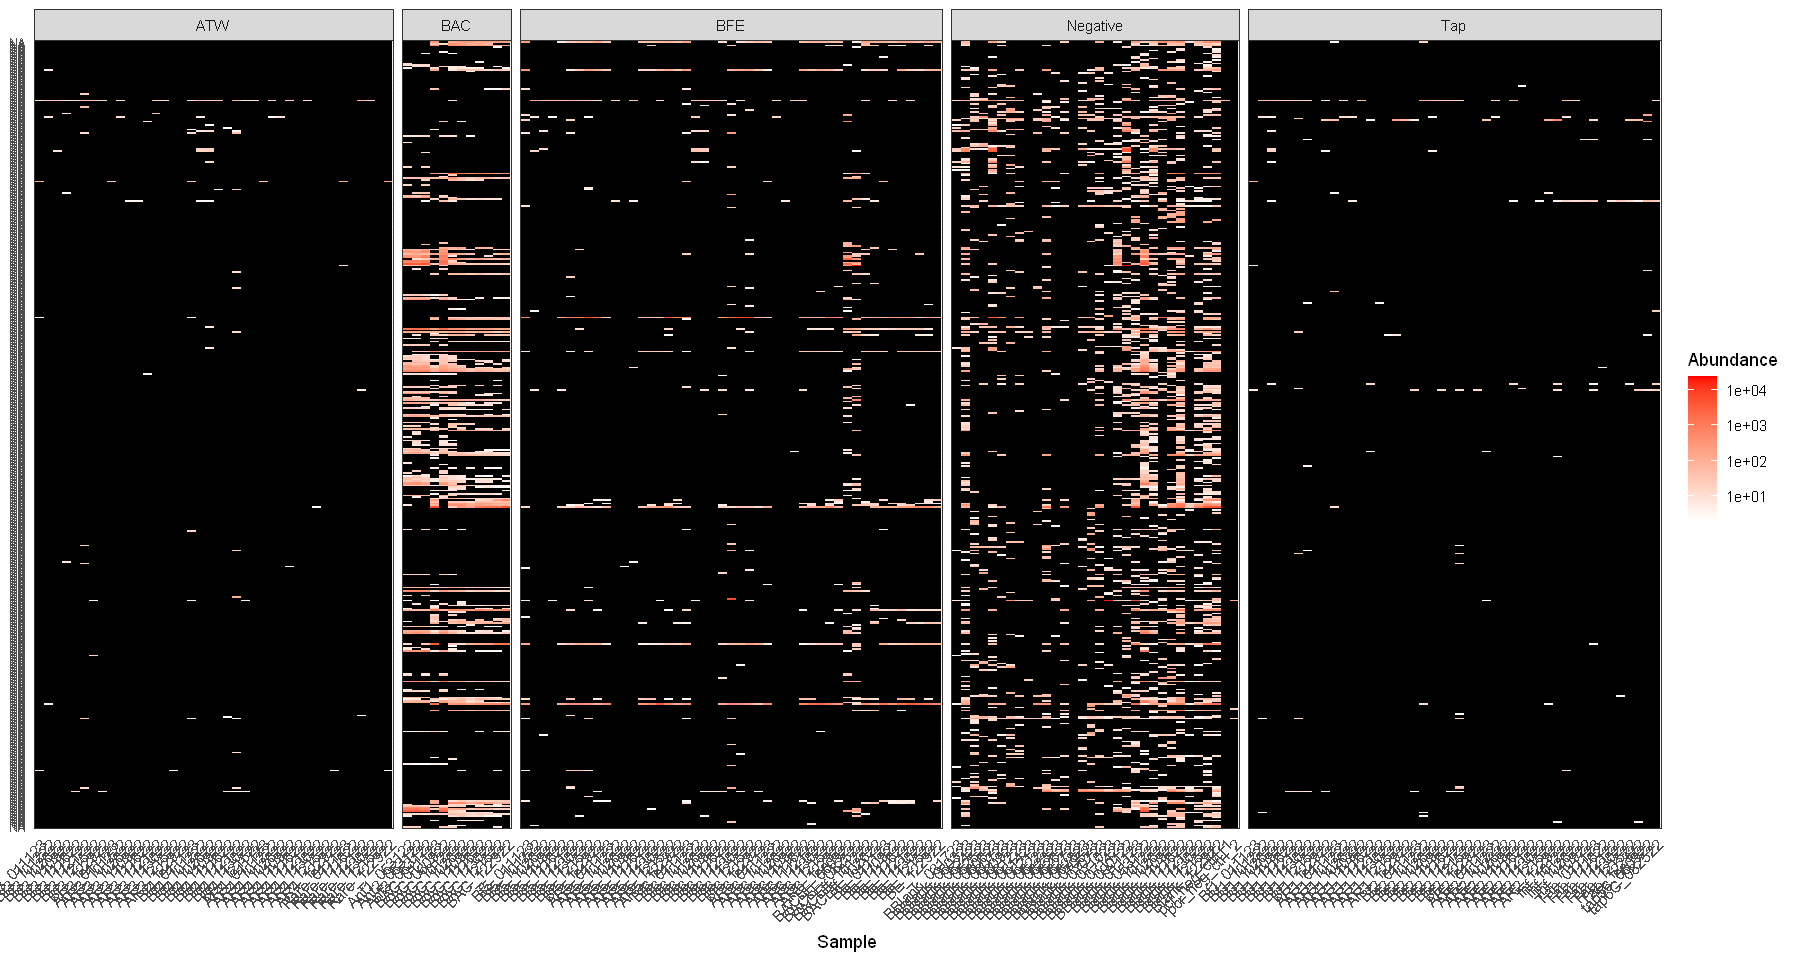

In [141]:
decontam_contams <- c(decontam_freq_intersect, decontam_prev_contams)
ps_decontam_contams <- prune_taxa(decontam_contams, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_decontam_contams, taxa.label = "combined",  sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_prev_contams.png', device='png', width=20, height=9)

In [146]:
ps_decontam_contams
length(decontam_contams)
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 487 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 487 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 487 reference sequences ]

[1] 488

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3761 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 3761 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3761 reference sequences ]

**ASVs flagged by prev/freq decontam. Several of these ASVs do look like contaminants that should be thrown out and were missed by decontam. Some look like they might be biological but the data is too sparse to be sure.**

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


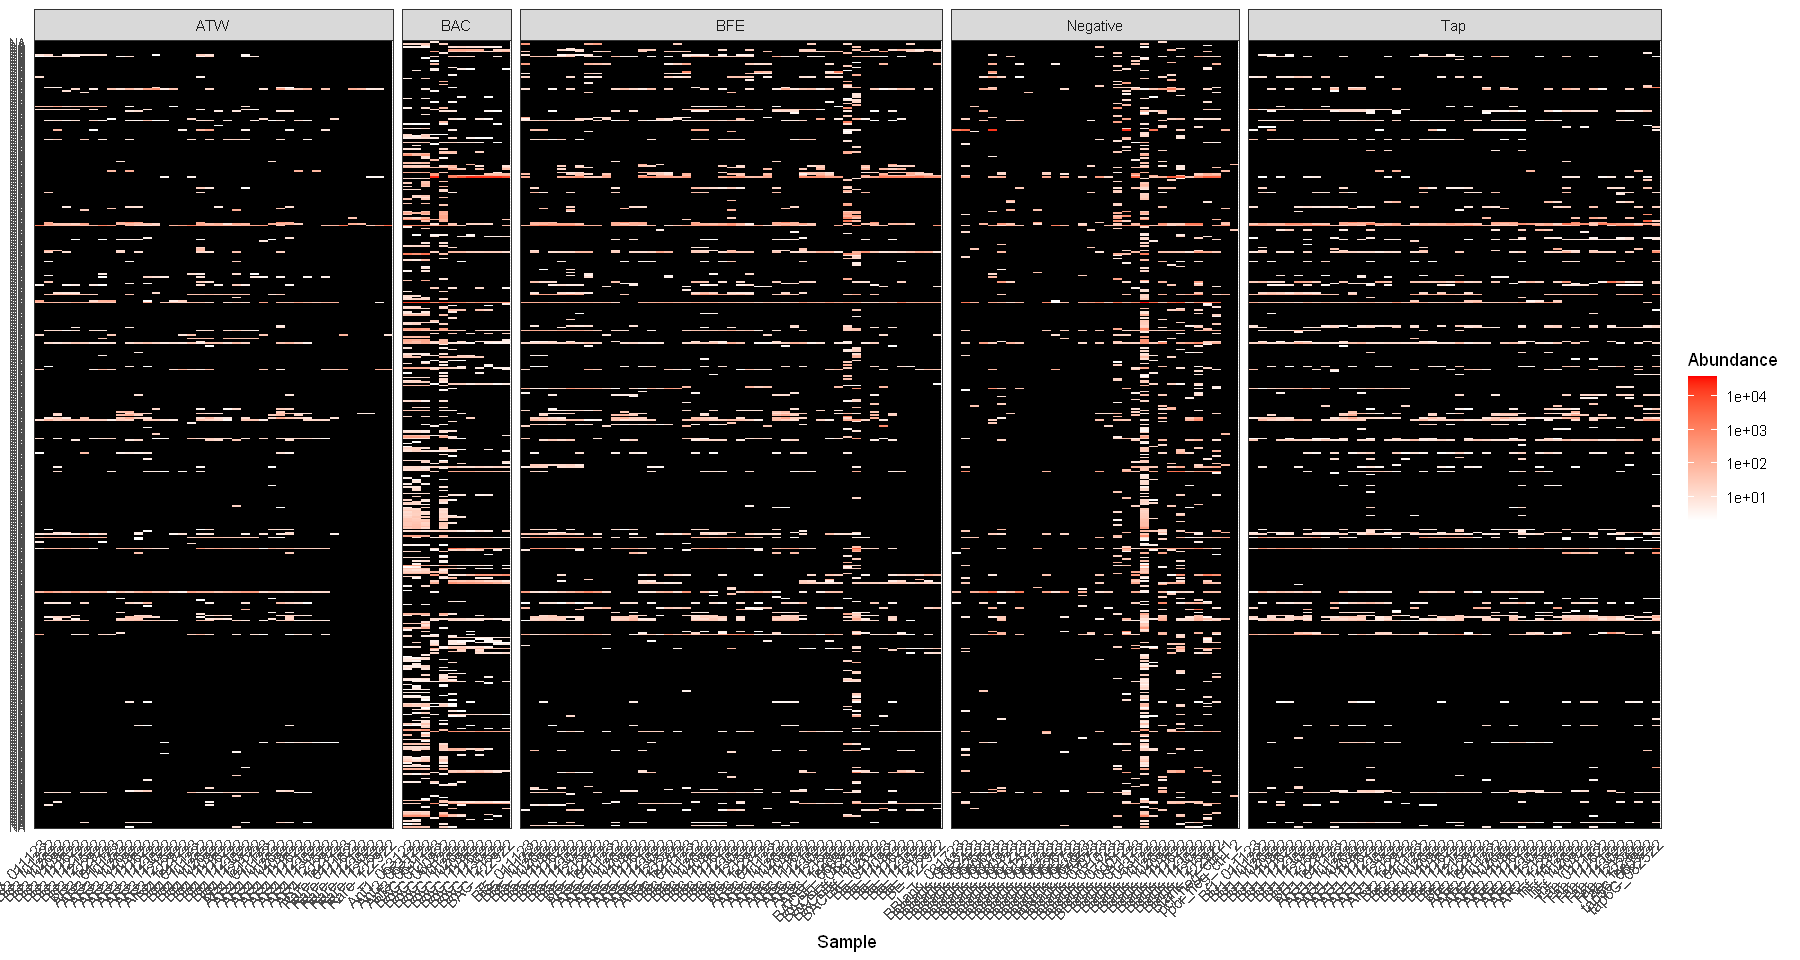

In [143]:
deseq_not_decontam <- setdiff(blanks_over_samples, decontam_contams)
ps_deseq_not_decontam <- prune_taxa(deseq_not_decontam, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_deseq_not_decontam, taxa.label = "combined",  sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_deseq_not_decontam.png', device='png', width=20, height=9)

**These are ASVs flagged by DESeq2 subtraction but not decontam. These are important ASVs that shouldn't be removed as contaminants. Likely their presence at very low abundance in the negative controls is due to cross-contamination from samples, where they are at high abundance.**

Warning message in scale_fill_gradient(low = low, high = high, trans = trans, na.value = na.value):
"log-10 transformation introduced infinite values."


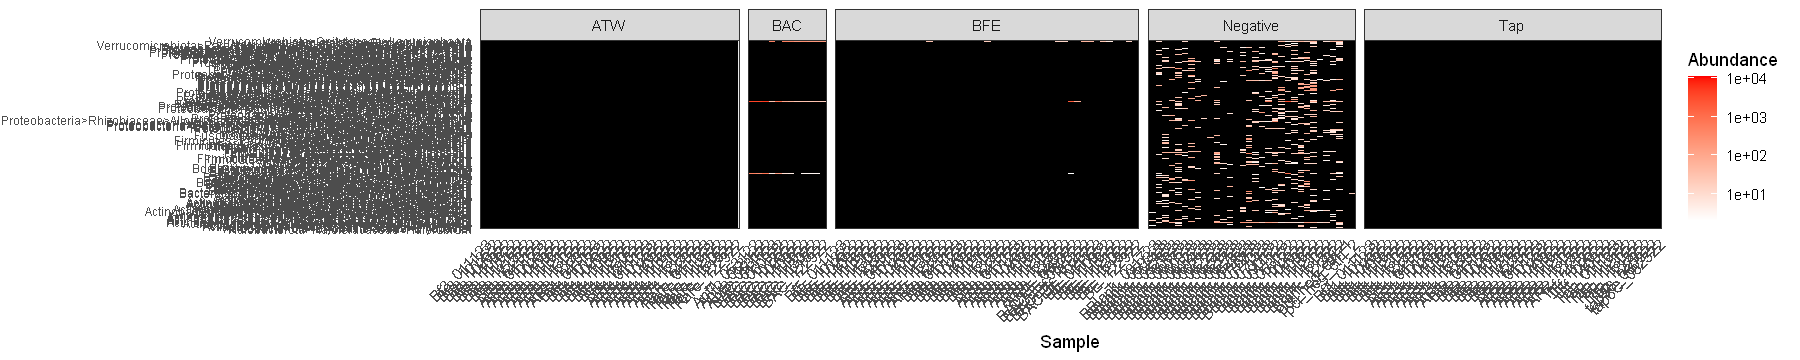

In [144]:
decontam_not_deseq <- setdiff(decontam_contams, blanks_over_samples)
ps_decontam_not_deseq <- prune_taxa(decontam_not_deseq, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 3)
plot_heatmap(ps_decontam_not_deseq, taxa.label = "combined",  sample.order = "Location", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Treatment, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_not_deseq.png', device='png', width=20, height=9)

**These are ASVs flagged by decontam but not DESeq2 subtraction.**

In [147]:
length(taxa_names(ps_decontam_contams))

[1] 487

In [148]:
length(taxa_names(ps_decontam_not_deseq))
length(taxa_names(ps_deseq_not_decontam))
length(taxa_names(ps_decontam_contams))

[1] 209

[1] 503

[1] 487

## Make New RDS

### Filter Out Env Taxa

In [149]:
ps_samp <- subset_samples(ps, subset = !(Treatment %in% c("Negative","Positive" )))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
samp_taxa <- taxa_names(ps_samp)


In [150]:
length(samp_taxa)

[1] 1972

In [151]:
not_contam <- setdiff(samp_taxa, decontam_contams)

In [152]:
ps_clean <- prune_taxa(not_contam, ps)
sample_data(ps_clean)$filtered_readcounts <- sample_sums(ps_clean)
ps_clean


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1690 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1690 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1690 reference sequences ]

### Remove Highly Contaminated Samples

In [153]:
metadata<- read.csv('C:\\Users\\almab\\16S\\metadata_v2.csv', header=TRUE, row.names = 1) %>% filter(id_full != 'Undetermined')

In [154]:
df <- as.data.frame(sample_data(ps_clean)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_clean)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

In [220]:
metadata %>%  filter(conc_before== 0.0100 &  DNA_Ext_conc_ngperuL>10)

,id_full,barcode_forward,barcode_reverse,plate,well,sample_date,sample_or_control,Sample_Type,type,Treatment,Location,DNA_Ext_conc_ngperuL,conc_before,contam_factor
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
AR2_111622,AR2_111622,CGTTACTA,GAGCTCAT,B,B7,11/16/2022,Sample,AR,Bulk,Tap,AR2 Bulk,28.8,0.01,2880
AR3_111622,AR3_111622,AGAGTCAC,GAGCTCAT,B,C7,11/16/2022,Sample,AR,Bulk,ATW,AR3 Bulk,30.3,0.01,3030
BAC_011123,BAC_011123,GCTCTAGT,TAGACTGA,C,E10,1/11/2023,Sample,Media,BAC,BAC,BAC Media,16.8,0.01,1680
Bf5_011123,Bf5_011123,CGTCGCTA,TAGACTGA,C,C10,1/11/2023,Sample,AR,Biofilm,BFE,AR5 Biofilm,13.1,0.01,1310
Bf6_011123,Bf6_011123,CTAGAGCT,TAGACTGA,C,D10,1/11/2023,Sample,AR,Biofilm,BFE,AR6 Biofilm,12.0,0.01,1200
Bf6_121522,Bf6_121522,ATATACAC,CTCTAGAG,C,B6,12/15/2022,Sample,AR,Biofilm,BFE,AR6 Biofilm,13.2,0.01,1320


In [166]:
metadata %>% filter(Treatment == 'Positive')

,id_full,barcode_forward,barcode_reverse,plate,well,sample_date,sample_or_control,Sample_Type,type,Treatment,Location,DNA_Ext_conc_ngperuL,conc_before,contam_factor
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
mock10_082523_1,mock10_082523_1,AGAGTCAC,TCGAGCTC,B,C12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,30.20,23.600,1.3
mock10_082523_2,mock10_082523_2,ACGACGTG,TCGAGCTC,C,A12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,25.70,1.260,20.4
mock6_082523_1,mock6_082523_1,ACGTCTCG,TCGAGCTC,B,E12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,9.93,0.010,993.0
mock6_082523_2,mock6_082523_2,CGTCGCTA,TCGAGCTC,C,C12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,8.86,0.010,886.0
mock8_082523_1,mock8_082523_1,TACGAGAC,TCGAGCTC,B,D12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,23.30,0.288,80.9
mock8_082523_2,mock8_082523_2,ATATACAC,TCGAGCTC,C,B12,8/25/2023,Control,Sequencing,Control,Positive,Positive Sequencing Control,23.40,0.164,142.7


In [214]:
# The following command filters out all negative controls that have >2ng/uL after PCR as these are the ones with the suspiciously high library size/read count in sequencing
# If the sample is too low before PCR and if above 10ng/uL after, based on the positive controls I will consider this a contaminanted sample. Similarly if the concentration factor is above 500. 
# I did not do the same for the biofilm samples above 0.01 with a high contam factor because these 7 samples were all biofilm samples early on in the experimental period meaning their DNA concentrations were likely to be low
# but it was not unreasonable they would be measurable after PCR

contam <- metadata %>% filter(if_else(sample_or_control=='Control', Treatment == 'Negative' & DNA_Ext_conc_ngperuL>2  , if_else(conc_before== 0.0100, DNA_Ext_conc_ngperuL>17,  contam_factor> 500 ) ))
#contam <- metadata %>% filter(if_else(sample_or_control=='Control', Treatment == 'Negative' & DNA_Ext_conc_ngperuL>2  , conc_before<0.0100  ))

contam

,id_full,barcode_forward,barcode_reverse,plate,well,sample_date,sample_or_control,Sample_Type,type,Treatment,Location,DNA_Ext_conc_ngperuL,conc_before,contam_factor
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
AR2_111622,AR2_111622,CGTTACTA,GAGCTCAT,B,B7,11/16/2022,Sample,AR,Bulk,Tap,AR2 Bulk,28.80,0.0100,2880.0
AR3_111622,AR3_111622,AGAGTCAC,GAGCTCAT,B,C7,11/16/2022,Sample,AR,Bulk,ATW,AR3 Bulk,30.30,0.0100,3030.0
BBlank_060623,BBlank_060623,CGTTACTA,TCACGATG,B,B11,6/6/2023,Control,Extraction,Control,Negative,Negative Extraction Control,6.54,0.0100,654.0
BBlank_090122,BBlank_090122,TGCGTACG,TCGAGCTC,C,G12,9/1/2022,Control,Extraction,Control,Negative,Negative Extraction Control,3.86,0.0100,386.0
Blank_011123,Blank_011123,GACACTGA,TAGACTGA,C,F10,1/11/2023,Control,Sample Day,Control,Negative,Negative Sample Control,5.50,0.0100,550.0
Blank_053122,Blank_053122,CTAGAGCT,TCACGATG,C,D11,5/31/2022,Control,Sample Day,Control,Negative,Negative Sample Control,11.60,0.0792,146.5
Blank_101222,Blank_101222,GTCAGATA,AGCGCTAT,B,H2,10/12/2022,Control,Sample Day,Control,Negative,Negative Sample Control,10.00,0.0720,138.9
Blank_102622,Blank_102622,GTCAGATA,CATGAGGA,B,H4,10/26/2022,Control,Sample Day,Control,Negative,Negative Sample Control,9.46,0.0100,946.0
Blank_110922,Blank_110922,GTCAGATA,CTCTAGAG,B,H6,11/9/2022,Control,Sample Day,Control,Negative,Negative Sample Control,4.16,0.0100,416.0


In [215]:
ps_filt <- subset_samples(ps_clean, !(sample_names(ps_clean) %in% contam$id_full))
ps_filt <- filter_taxa(ps_filt, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1678 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1678 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1678 reference sequences ]

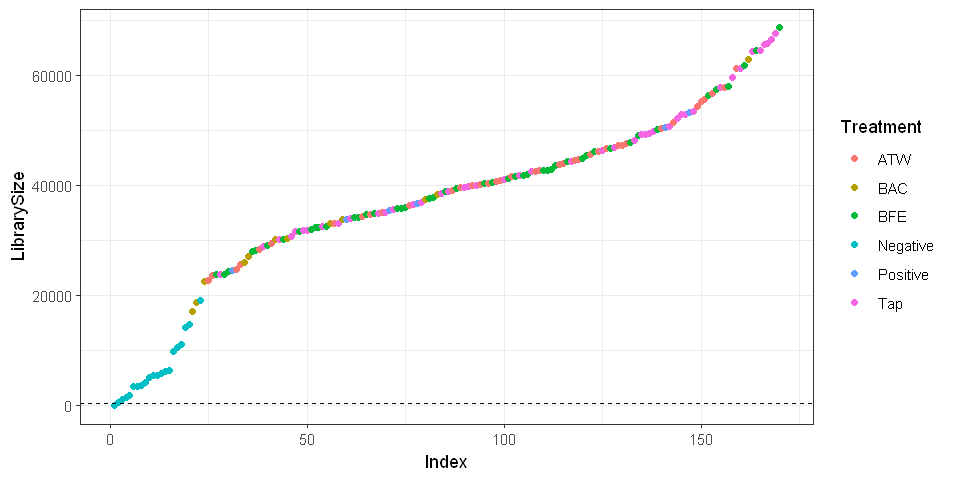

In [216]:
min_reads <- 300
df <- as.data.frame(sample_data(ps_filt)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_filt)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=Treatment))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')

### Save New File(s)

In [217]:
#ps_clean_filt <- prune_samples(sample_sums(ps_filt)>=300, ps_filt) #remove samples now with too few reads
ps_clean_filt <- filter_taxa(ps_filt, filterfun(kOverA(1, 0)), TRUE)
ps_clean_perc <- transform_sample_counts(ps_clean_filt, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_clean
ps_filt
ps_clean_filt
                                              
#saveRDS(ps_clean, "C:/Users/almab/16S/ps_clean.rds")
#saveRDS(ps_filt, "C:/Users/almab/16S/ps_filt.rds")
saveRDS(ps_clean_filt, "C:/Users/almab/16S/ps_clean_filt.rds")
saveRDS(ps_clean_perc, "C:/Users/almab/16S/ps_clean_perc.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1690 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1690 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1690 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1678 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1678 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1678 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1678 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 1678 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 1678 reference sequences ]